In [ ]:
pip install optuna

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer #, KNNImputer, IterativeImputer

In [2]:
from google.colab import drive
# Load the dataset
# Assuming the dataset is a CSV file in Google Drive
data = pd.read_csv('/content/drive/My Drive/mayhoc/train.csv')

In [ ]:
# Get unique classes
unique_classes = data['Label'].unique()

# Count the number of classes
num_classes = len(unique_classes)
# Count the number of columns
num_columns = data.shape[1]

# Data distribution for the "Label" column
label_distribution = data['Label'].value_counts()

# Print the results
print(f"Number of columns: {num_columns}")
print("\nData Distribution by 'Label':")
print(label_distribution)

# Print the results
print(f"Number of unique classes: {num_classes}")
print("Classes:", unique_classes)

In [4]:
# Replace inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Explicitly name the target column
target_column = 'Label'

# Encode the labels
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])

# Separating out the features and target
features = data.drop(columns=[target_column, 'ID', 'Weight']).columns  # Exclude "Weight" from features
X = data.loc[:, features].values
y = data.loc[:, target_column].values
weights = data["Weight"].values  # Get the weights

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_x = imputer.fit_transform(X)

# Split data into training and testing sets, including weights
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

In [ ]:
## Optimize hyperparamater using optuna
import optuna
## Define objective function
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )
    model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Return MAE
    return mae

# Create study object
study = optuna.create_study(direction="minimize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

In [ ]:
import matplotlib.pyplot as plt

# 1. Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42,n_jobs=-1,verbose=2)

# 2. Train the model with sample weights
rf_classifier.fit(X_train, y_train, sample_weight=weights_train)

# 3. Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# 4. Calculate weighted accuracy and F1-score
weighted_accuracy = accuracy_score(y_test, y_pred, sample_weight=weights_test)
weighted_f1 = f1_score(y_test, y_pred, average="weighted", sample_weight=weights_test)

print(classification_report(y_test, y_pred))

print(f"Weighted Accuracy: {weighted_accuracy:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


            Feature  Gini Importance
39              IAT     2.425483e-01
36              AVG     5.363118e-02
41         Magnitue     5.093892e-02
1     Header_Length     4.795822e-02
2     Protocol type     4.730398e-02
18        rst_count     3.944724e-02
0     flow_duration     3.931054e-02
8   syn_flag_number     3.169399e-02
35              Max     3.089700e-02
38         Tot size     3.069072e-02
33          Tot sum     2.932664e-02
34              Min     2.759764e-02
17        urg_count     2.741711e-02
15        syn_count     2.664801e-02
5             Srate     2.588594e-02
4              Rate     2.363772e-02
40           Number     2.192121e-02
30             ICMP     2.177611e-02
27              UDP     2.076680e-02
16        fin_count     1.969205e-02
14        ack_count     1.801563e-02
7   fin_flag_number     1.791355e-02
44         Variance     1.643159e-02
43       Covariance     1.433296e-02
42           Radius     1.345821e-02
37              Std     1.304458e-02
1

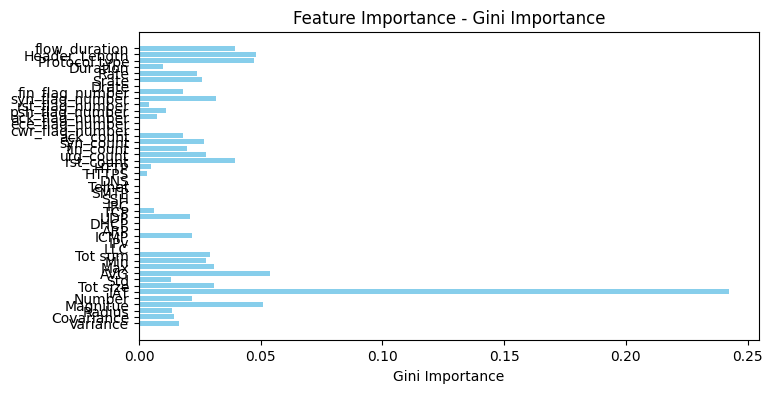

In [8]:
# Importance Features witch Scikit Learn
# Built-in feature importance (Gini Importance)
importances = rf_classifier.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [ ]:
# export model using packle
import pickle
import gzip

# save the iris classification model as a pickle file
model_pkl_file = "ddos-detection.pkl"

# with open(model_pkl_file, 'wb') as file:
with gzip.open(model_pkl_file, 'wb') as file:
    pickle.dump(rf_classifier, file)